In [1]:
import matplotlib.pyplot as plt
import subprocess
import sys
sys.path.append("../")
from utils import createXYPlot
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
df_vax = pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.csv")

In [2]:
df_vax.columns

Index(['data_somministrazione', 'fornitore', 'area', 'fascia_anagrafica',
       'sesso_maschile', 'sesso_femminile', 'prima_dose', 'seconda_dose',
       'pregressa_infezione', 'dose_addizionale_booster', 'codice_NUTS1',
       'codice_NUTS2', 'codice_regione_ISTAT', 'nome_area'],
      dtype='object')

In [3]:
fornitori = sorted(df_vax.fornitore.unique())
anagrafiche = sorted(df_vax.fascia_anagrafica.unique())

In [4]:
oggi = np.max(df_vax["data_somministrazione"])
plots_folder = f"./plots/{oggi}/vaccination"
print(plots_folder)
res = subprocess.check_output(f"mkdir -p {plots_folder}",shell=True)

./plots/2022-01-26/vaccination


In [5]:
def group_by_doses(df, keys, columns):
    agg_dict = {c:"sum" for c in columns}
    df = df.groupby(keys).agg(agg_dict).reset_index()
    return df

In [6]:
def get_grid(keys):
    grid = pd.DataFrame()
    for f in keys:
        new_grid = pd.DataFrame(df_vax[f].unique(), columns=[f])
        new_grid['key'] = 0
        grid['key'] = 0
        grid = grid.merge(new_grid, on='key', how='outer')
    grid = grid.sort_values(by=keys).reset_index(drop=True)
    return grid.drop(["key"],axis=1)

In [8]:
def roll_mean(df, key=None):
    df = df.set_index("data_somministrazione")
    col_names = [c for c in df.columns if "dose" in c]
    print(col_names)
    for cname in col_names:
        if key is not None:
            df_roll = pd.DataFrame(df.groupby(key)[cname].rolling(7).mean())
            df_roll = df_roll.rename(columns={cname: f"{cname}_media_7"})
            for k in key:
                df = df.set_index(k, append=True)
            df = df.join(df_roll).reset_index().set_index("data_somministrazione")
        else:
            df[f"{cname}_media_7"] = df[cname].rolling(7).mean()
    
    return df.reset_index()

In [9]:
df_vax["terza_dose"] = df_vax["dose_addizionale_booster"]
df_vax["prima_dose_no_guariti"] = df_vax["prima_dose"]
df_vax["prima_dose"] = df_vax["prima_dose"] + df_vax["pregressa_infezione"]

In [10]:
cols_to_sum = ["prima_dose", "seconda_dose", "terza_dose", "pregressa_infezione", "prima_dose_no_guariti"]
df_vax_yyyy_mm_dd = group_by_doses(df_vax, keys=["data_somministrazione"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_fornitore = group_by_doses(df_vax, keys=["data_somministrazione", "fornitore"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_anag = group_by_doses(df_vax, keys=["data_somministrazione", "fascia_anagrafica"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_anag_fornitore = group_by_doses(df_vax, keys=["data_somministrazione", "fascia_anagrafica", "fornitore"], columns=cols_to_sum)

In [11]:
pd.DataFrame(df_vax_yyyy_mm_dd[["prima_dose",
                                "seconda_dose",
                                "terza_dose",
                                "pregressa_infezione",
                                "prima_dose_no_guariti"
                               ]].agg(sum),columns=["totale"])

totale
prima_dose             49923700
seconda_dose           44275723
terza_dose             31580302
pregressa_infezione     1736964
prima_dose_no_guariti  48186736

In [12]:
df_vax_yyyy_mm_dd_pediatrico=df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore=="Pfizer Pediatrico"].drop(columns="fornitore")
df_vax_yyyy_mm_dd = df_vax_yyyy_mm_dd.merge(df_vax_yyyy_mm_dd_pediatrico, on="data_somministrazione", how="left", suffixes=("","_pediatrico"))
for n_dos in ["prima", "seconda", "terza"]:
    df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"] = df_vax_yyyy_mm_dd[f"{n_dos}_dose"] - df_vax_yyyy_mm_dd[f"{n_dos}_dose_pediatrico"]
    df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"] = df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"].combine_first(df_vax_yyyy_mm_dd[f"{n_dos}_dose"])
    
    
    

In [13]:
df_vax_yyyy_mm_dd

data_somministrazione  prima_dose  seconda_dose  terza_dose  \
0              2020-12-27        7346             0           0   
1              2020-12-28        1503             0           0   
2              2020-12-29        1119             0           0   
3              2020-12-30        4867             0           0   
4              2020-12-31       25935             0           0   
5              2021-01-01       11266             0           0   
6              2021-01-02       39058             0           0   
7              2021-01-03       35871             0           0   
8              2021-01-04       69326             0           0   
9              2021-01-05       80221             0           0   
10             2021-01-06       65167             0           0   
11             2021-01-07       92615             0           0   
12             2021-01-08       95243             0           0   
13             2021-01-09       85642             0           0   
14             2021-01-10       60916             0           0   
15             2021-01-11       82140             0           0   
16             2021-01-12       83497             0           0   
17             2021-01-13       95101             0           0   
18             2021-01-14       94448             0           0   
19             2021-01-15       90969             0           0   
20             2021-01-16       66110             0           0   
21             2021-01-17       34623          2989           0   
22             2021-01-18       39568          5096           0   
23             2021-01-19       31573          1789           0   
24             2021-01-20       26951          4605           0   
25             2021-01-21       16593         19958           0   
26             2021-01-22       13222         14162           0   
27             2021-01-23        6031         33339           0   
28             2021-01-24        3247         30782           0   
29             2021-01-25        4870         64751           0   
30             2021-01-26        4318         76525           0   
31             2021-01-27        6373         64859           0   
32             2021-01-28        4915         89300           0   
33             2021-01-29        5062         94046           0   
34             2021-01-30        4166         84331           0   
35             2021-01-31        2648         57334           0   
36             2021-02-01        4326         81868           0   
37             2021-02-02        6468         82124           0   
38             2021-02-03        9100         91168           0   
39             2021-02-04       13275         94474           0   
40             2021-02-05       17987         90181           0   
41             2021-02-06       14718         63645           0   
42             2021-02-07        9545         32864           0   
43             2021-02-08       26944         40276           0   
44             2021-02-09       34578         32681           0   
45             2021-02-10       45147         28170           0   
46             2021-02-11       55412         19895           0   
47             2021-02-12       59079         15508           0   
48             2021-02-13       46154          6778           0   
49             2021-02-14       27424          2603           0   
50             2021-02-15       57036          6052           0   
51             2021-02-16       65313          6210           0   
52             2021-02-17       71115          9599           0   
53             2021-02-18       82454          8138           0   
54             2021-02-19       86805          6800           0   
55             2021-02-20       73993          4513           0   
56             2021-02-21       48988          2253           0   
57             2021-02-22      100713          5398           0   
58             2021-02-23      101477          5484

In [14]:
df_vax_yyyy_mm_dd = roll_mean(df_vax_yyyy_mm_dd)
df_vax_yyyy_mm_dd_fornitore = roll_mean(df_vax_yyyy_mm_dd_fornitore,key=["fornitore"])
df_vax_yyyy_mm_dd_anag_fornitore = roll_mean(df_vax_yyyy_mm_dd_anag_fornitore,key=["fornitore","fascia_anagrafica"])
df_vax_yyyy_mm_dd_anag = roll_mean(df_vax_yyyy_mm_dd_anag, key=["fascia_anagrafica"])

['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti', 'prima_dose_pediatrico', 'seconda_dose_pediatrico', 'terza_dose_pediatrico', 'prima_dose_no_guariti_pediatrico', 'prima_dose_adulti', 'seconda_dose_adulti', 'terza_dose_adulti']
['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti']
['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti']
['prima_dose', 'seconda_dose', 'terza_dose', 'prima_dose_no_guariti']


In [15]:
df_vax_yyyy_mm_dd[["data_somministrazione","prima_dose","prima_dose_adulti","prima_dose_pediatrico"]]

data_somministrazione  prima_dose  prima_dose_adulti  \
0              2020-12-27        7346             7346.0   
1              2020-12-28        1503             1503.0   
2              2020-12-29        1119             1119.0   
3              2020-12-30        4867             4867.0   
4              2020-12-31       25935            25935.0   
5              2021-01-01       11266            11266.0   
6              2021-01-02       39058            39058.0   
7              2021-01-03       35871            35871.0   
8              2021-01-04       69326            69326.0   
9              2021-01-05       80221            80221.0   
10             2021-01-06       65167            65167.0   
11             2021-01-07       92615            92615.0   
12             2021-01-08       95243            95243.0   
13             2021-01-09       85642            85642.0   
14             2021-01-10       60916            60916.0   
15             2021-01-11       82140            82140.0   
16             2021-01-12       83497            83497.0   
17             2021-01-13       95101            95101.0   
18             2021-01-14       94448            94448.0   
19             2021-01-15       90969            90969.0   
20             2021-01-16       66110            66110.0   
21             2021-01-17       34623            34623.0   
22             2021-01-18       39568            39568.0   
23             2021-01-19       31573            31573.0   
24             2021-01-20       26951            26951.0   
25             2021-01-21       16593            16593.0   
26             2021-01-22       13222            13222.0   
27             2021-01-23        6031             6031.0   
28             2021-01-24        3247             3247.0   
29             2021-01-25        4870             4870.0   
30             2021-01-26        4318             4318.0   
31             2021-01-27        6373             6373.0   
32             2021-01-28        4915             4915.0   
33             2021-01-29        5062             5062.0   
34             2021-01-30        4166             4166.0   
35             2021-01-31        2648             2648.0   
36             2021-02-01        4326             4326.0   
37             2021-02-02        6468             6468.0   
38             2021-02-03        9100             9100.0   
39             2021-02-04       13275            13275.0   
40             2021-02-05       17987            17987.0   
41             2021-02-06       14718            14718.0   
42             2021-02-07        9545             9545.0   
43             2021-02-08       26944            26944.0   
44             2021-02-09       34578            34578.0   
45             2021-02-10       45147            45147.0   
46             2021-02-11       55412            55412.0   
47             2021-02-12       59079            59079.0   
48             2021-02-13       46154            46154.0   
49             2021-02-14       27424            27424.0   
50             2021-02-15       57036            57036.0   
51             2021-02-16       65313            65313.0   
52             2021-02-17       71115            71115.0   
53             2021-02-18       82454            82454.0   
54             2021-02-19       86805            86805.0   
55             2021-02-20       73993            73993.0   
56             2021-02-21       48988            48988.0   
57             2021-02-22      100713           100713.0   
58             2021-02-23      101477           101477.0   
59             2021-02-24      114467           114467.0   
60             2021-02-25      116646           116646.0   
61             2021-02-26      123703           123703.0   
62             2021-02-27      115151           115151.0   
63             2021-02-28       70251            70251.0   
64             2021-03-01      111611           111611.0   
65             2021-03-02      131667       

In [16]:
fornitori = df_vax_yyyy_mm_dd_fornitore["fornitore"].unique()

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


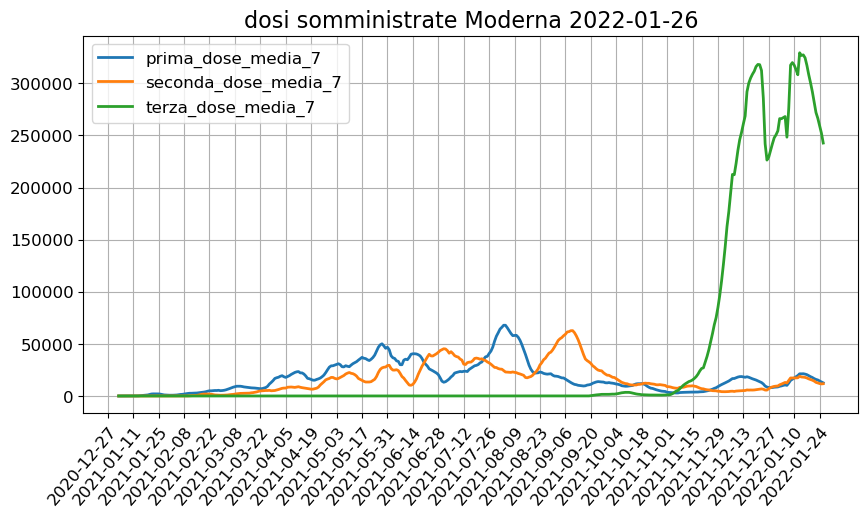

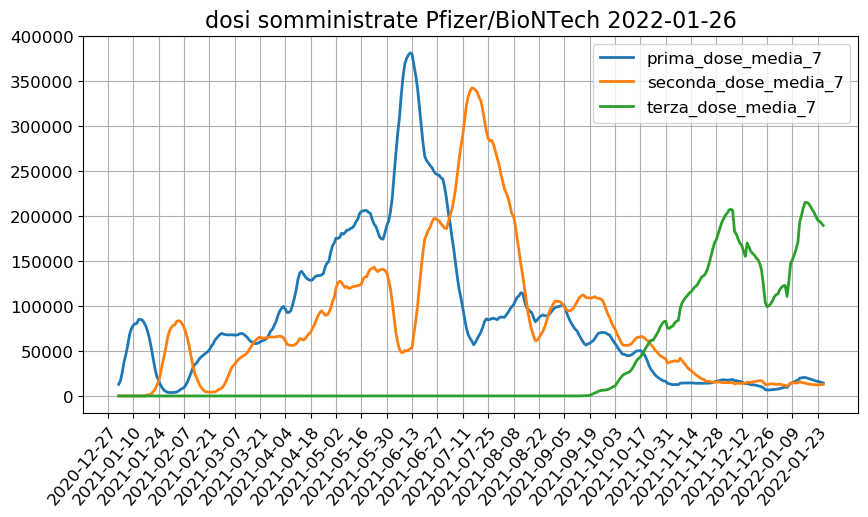

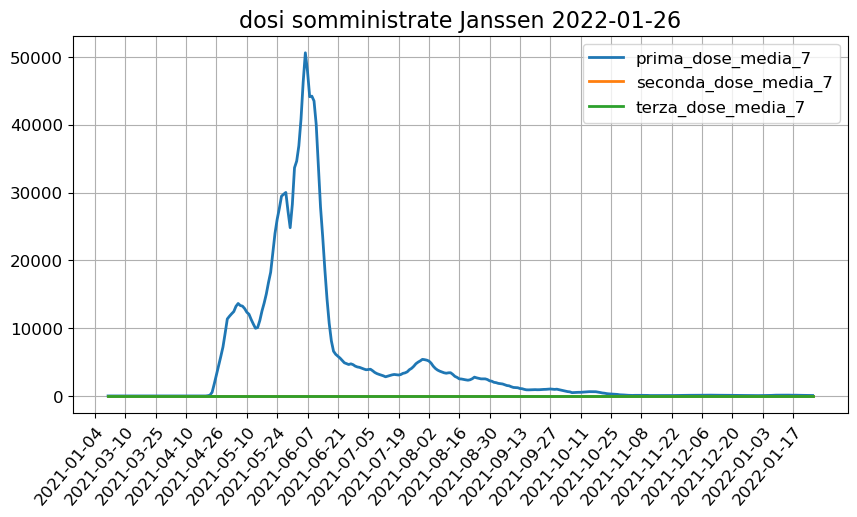

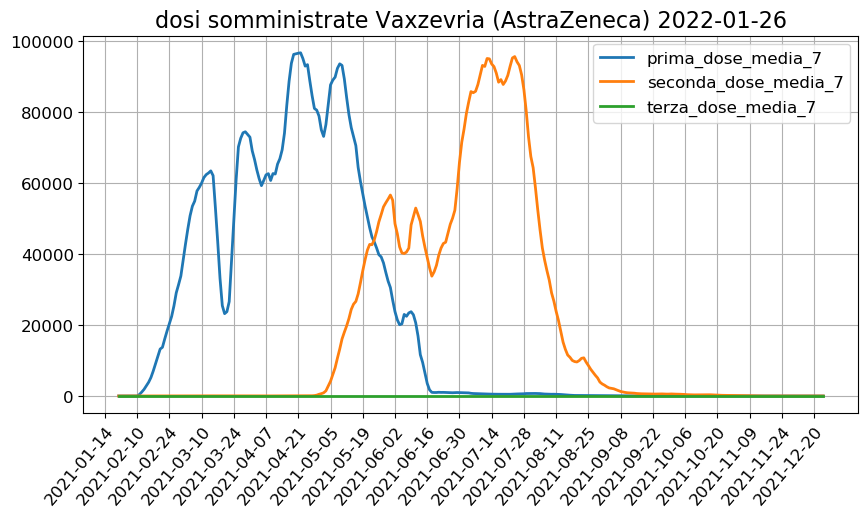

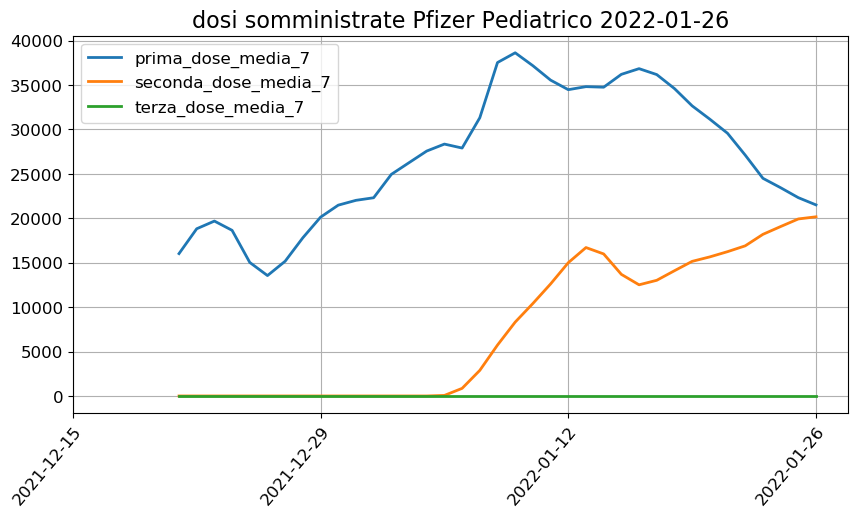

In [17]:
for fornitore in fornitori:
    savename_suffix="_"+fornitore.replace("/","_")
    df_plot = df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore==fornitore]
    df_plot = df_plot.sort_values(by="data_somministrazione")
    df_plot["prima_dose_media_7"] = df_plot["prima_dose"].rolling(7).mean()
    df_plot["seconda_dose_media_7"] = df_plot["seconda_dose"].rolling(7).mean()
    df_plot["terza_dose_media_7"] = df_plot["terza_dose"].rolling(7).mean()
    createXYPlot(df_plot, 
                 y=["prima_dose_media_7","seconda_dose_media_7","terza_dose_media_7"], 
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"dosi somministrate {fornitore} {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate{savename_suffix}.png")

In [18]:
df_vax_yyyy_mm_dd.tail(15)

data_somministrazione  prima_dose  seconda_dose  terza_dose  \
381            2022-01-12       79749         51796      579331   
382            2022-01-13       74417         52407      578444   
383            2022-01-14       78075         40442      586335   
384            2022-01-15       97851         32051      566944   
385            2022-01-16       65729         26349      340465   
386            2022-01-17       58815         49909      488034   
387            2022-01-18       59495         53595      515353   
388            2022-01-19       55088         52604      500766   
389            2022-01-20       54325         49892      496213   
390            2022-01-21       54480         37631      490850   
391            2022-01-22       70287         26117      466841   
392            2022-01-23       40744         31996      273670   
393            2022-01-24       40667         52662      433366   
394            2022-01-25       40884         57871      446239   
395            2022-01-26       38860         58093      418734   

     pregressa_infezione  prima_dose_no_guariti  prima_dose_pediatrico  \
381                 1856                  77893                34240.0   
382                 1800                  72617                31075.0   
383                 1929                  76146                33907.0   
384                 2032                  95819                56328.0   
385                 1311                  64418                42503.0   
386                 1771                  57044                21535.0   
387                 1776                  57719                22565.0   
388                 1884                  53204                20618.0   
389                 1737                  52588                20564.0   
390                 1808                  52672                22808.0   
391                 1972                  68315                39128.0   
392                 1091                  39653                24243.0   
393                 1570                  39097                14125.0   
394                 1565                  39319                14731.0   
395                 1425                  37435                14913.0   

     seconda_dose_pediatrico  terza_dose_pediatrico  \
381                  17177.0                    0.0   
382                  17495.0                    0.0   
383                   9136.0                    0.0   
384                   3846.0                    0.0   
385                   9860.0                    0.0   
386                  18222.0                    0.0   
387                  22915.0                    0.0   
388                  24559.0                    0.0   
389                  21023.0                    0.0   
390                  13246.0                    0.0   
391                   8438.0                    0.0   
392                  18909.0                    0.0   
393                  24360.0                    0.0   
394                  28904.0                    0.0   
395                  26255.0                    0.0   

     pregressa_infezione_pediatrico  ...  seconda_dose_media_7  \
381                            92.0  ...          46905.285714   
382                           105.0  ...          51608.714286   
383                           105.0  ...          49307.000000   
384                           192.0  ...          46259.857143   
385                           177.0  ...          44702.571429   
386                            87.0  ...          43995.142857   
387                            89.0  ...          43792.714286   
388                            73.0  ...          43908.142857   
389                            81.0  ...          43548.857143   
390                            96.0  ...          43147.285714   
391                           215.0  ...          42299.571429   
392                           106.0  ...          43106.285714   
393    

In [19]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [20]:
df_vax_yyyy_mm_dd

data_somministrazione  prima_dose  seconda_dose  terza_dose  \
0              2020-12-27        7346             0           0   
1              2020-12-28        1503             0           0   
2              2020-12-29        1119             0           0   
3              2020-12-30        4867             0           0   
4              2020-12-31       25935             0           0   
5              2021-01-01       11266             0           0   
6              2021-01-02       39058             0           0   
7              2021-01-03       35871             0           0   
8              2021-01-04       69326             0           0   
9              2021-01-05       80221             0           0   
10             2021-01-06       65167             0           0   
11             2021-01-07       92615             0           0   
12             2021-01-08       95243             0           0   
13             2021-01-09       85642             0           0   
14             2021-01-10       60916             0           0   
15             2021-01-11       82140             0           0   
16             2021-01-12       83497             0           0   
17             2021-01-13       95101             0           0   
18             2021-01-14       94448             0           0   
19             2021-01-15       90969             0           0   
20             2021-01-16       66110             0           0   
21             2021-01-17       34623          2989           0   
22             2021-01-18       39568          5096           0   
23             2021-01-19       31573          1789           0   
24             2021-01-20       26951          4605           0   
25             2021-01-21       16593         19958           0   
26             2021-01-22       13222         14162           0   
27             2021-01-23        6031         33339           0   
28             2021-01-24        3247         30782           0   
29             2021-01-25        4870         64751           0   
30             2021-01-26        4318         76525           0   
31             2021-01-27        6373         64859           0   
32             2021-01-28        4915         89300           0   
33             2021-01-29        5062         94046           0   
34             2021-01-30        4166         84331           0   
35             2021-01-31        2648         57334           0   
36             2021-02-01        4326         81868           0   
37             2021-02-02        6468         82124           0   
38             2021-02-03        9100         91168           0   
39             2021-02-04       13275         94474           0   
40             2021-02-05       17987         90181           0   
41             2021-02-06       14718         63645           0   
42             2021-02-07        9545         32864           0   
43             2021-02-08       26944         40276           0   
44             2021-02-09       34578         32681           0   
45             2021-02-10       45147         28170           0   
46             2021-02-11       55412         19895           0   
47             2021-02-12       59079         15508           0   
48             2021-02-13       46154          6778           0   
49             2021-02-14       27424          2603           0   
50             2021-02-15       57036          6052           0   
51             2021-02-16       65313          6210           0   
52             2021-02-17       71115          9599           0   
53             2021-02-18       82454          8138           0   
54             2021-02-19       86805          6800           0   
55             2021-02-20       73993          4513           0   
56             2021-02-21       48988          2253           0   
57             2021-02-22      100713          5398           0   
58             2021-02-23      101477          5484

In [21]:
np.sum(df_vax_yyyy_mm_dd[df_vax_yyyy_mm_dd.data_somministrazione>"2021-12-26"][["prima_dose_adulti"]])

prima_dose_adulti    929356.0
dtype: float64

In [22]:
cond = (df_vax_yyyy_mm_dd_anag.data_somministrazione>"2021-12-26") & (df_vax_yyyy_mm_dd_anag.fascia_anagrafica.isin(["50-59","60-69","70-79","80-89","90+"])) 
    
display(df_vax_yyyy_mm_dd_anag[cond][["data_somministrazione","fascia_anagrafica","prima_dose"]])

np.sum(df_vax_yyyy_mm_dd_anag[cond][["prima_dose"]])

data_somministrazione fascia_anagrafica  prima_dose
3297            2021-12-27             50-59        2774
3298            2021-12-27             60-69        1728
3299            2021-12-27             70-79         981
3300            2021-12-27             80-89         404
3301            2021-12-27               90+          88
3307            2021-12-28             50-59        3158
3308            2021-12-28             60-69        1966
3309            2021-12-28             70-79        1156
3310            2021-12-28             80-89         567
3311            2021-12-28               90+         150
3317            2021-12-29             50-59        3200
3318            2021-12-29             60-69        2074
3319            2021-12-29             70-79        1249
3320            2021-12-29             80-89         603
3321            2021-12-29               90+         177
3327            2021-12-30             50-59        3364
3328            2021-12-30             60-69        2197
3329            2021-12-30             70-79        1335
3330            2021-12-30             80-89         628
3331            2021-12-30               90+         191
3337            2021-12-31             50-59        1669
3338            2021-12-31             60-69         981
3339            2021-12-31             70-79         512
3340            2021-12-31             80-89         253
3341            2021-12-31               90+          73
3347            2022-01-01             50-59         418
3348            2022-01-01             60-69         225
3349            2022-01-01             70-79         111
3350            2022-01-01             80-89          44
3351            2022-01-01               90+           7
3357            2022-01-02             50-59        1792
3358            2022-01-02             60-69         937
3359            2022-01-02             70-79         461
3360            2022-01-02             80-89         249
3361            2022-01-02               90+          47
3367            2022-01-03             50-59        4042
3368            2022-01-03             60-69        2402
3369            2022-01-03             70-79        1263
3370            2022-01-03             80-89         565
3371            2022-01-03               90+         153
3377            2022-01-04             50-59        4258
3378            2022-01-04             60-69        2688
3379            2022-01-04             70-79        1459
3380            2022-01-04             80-89         723
3381            2022-01-04               90+         194
3387            2022-01-05             50-59        3858
3388            2022-01-05             60-69        2418
3389            2022-01-05             70-79        1442
3390            2022-01-05             80-89         678
3391            2022-01-05               90+         216
3397            2022-01-06             50-59        2713
3398            2022-01-06             60-69        1593
3399            2022-01-06             70-79         783
3400            2022-01-06             80-89         371
3401            2022-01-06               90+          64
3407            2022-01-07             50-59        7069
3408            2022-01-07             60-69        4876
3409            2022-01-07             70-79        2814
3410            2022-01-07             80-89        1109
3411            2022-01-07               90+         269
3417            2022-01-08             50-59        6586
3418            2022-01-08             60-69        4641
3419            2022-01-08             70-79        2620
3420            2022-01-08             80-89        1105
3421            2022-01-08               90+         217
3427            2022-01-09             50-59        4974
3428            2022-01-09             60-69        3175
3429            2022-01-09             70-79        1617
3430            2022-01-09             80-89         690
3431           

prima_dose    393687
dtype: int64

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


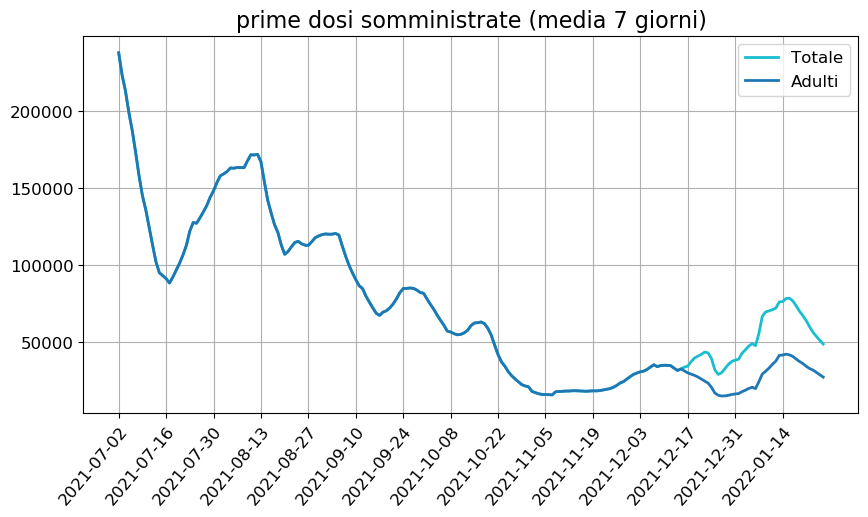

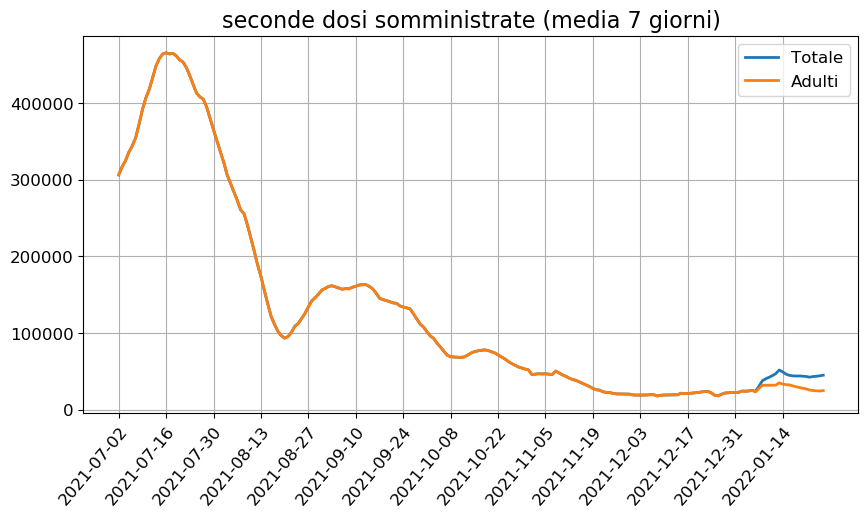

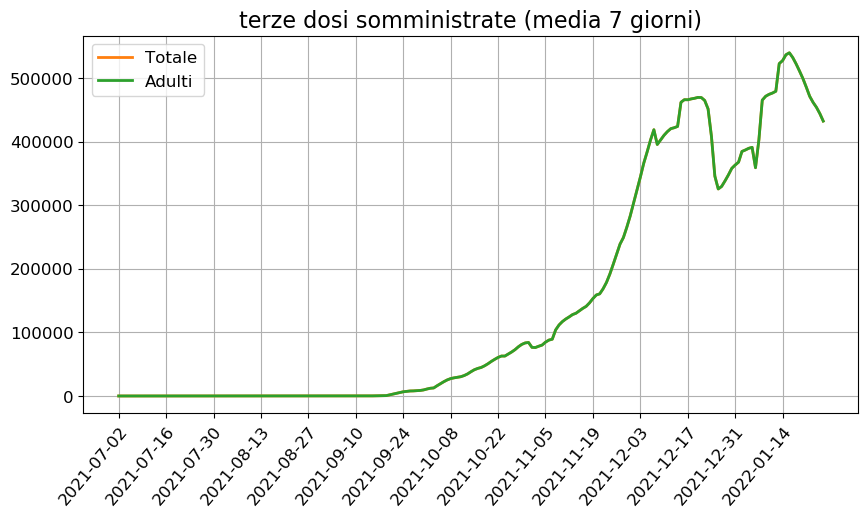

In [23]:
i = 0
for dose in ["prima","seconda","terza"]:
    
    createXYPlot(df_vax_yyyy_mm_dd, 
                 y=[
                    f"{dose}_dose_media_7",
                    f"{dose}_dose_adulti_media_7",
                    
                   ],
                 labels=["Totale","Adulti"],
                 colors=[colors[i-1],colors[i]],
                 alphas=[1,1],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 start_date="2021-07-01",
                 title=f"{dose.replace('a','e')} dosi somministrate (media 7 giorni)",
                 plots_folder=plots_folder,
                 savename=f"{dose.replace('a','e')}_dosi_somministrate.png"
                )
    i +=1

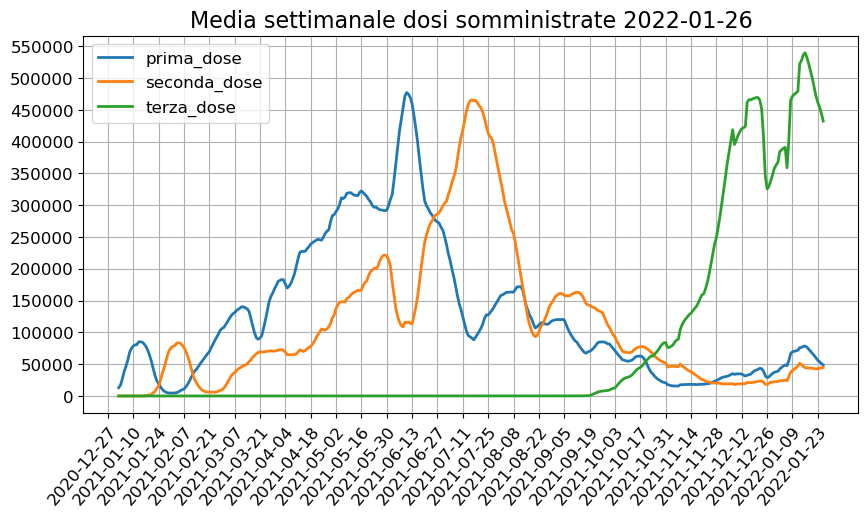

In [49]:
createXYPlot(df_vax_yyyy_mm_dd, 
                 y=["prima_dose_media_7","seconda_dose_media_7","terza_dose_media_7"], 
                 labels=["prima_dose", "seconda_dose", "terza_dose"],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"Media settimanale dosi somministrate {oggi}",
                 plots_folder=plots_folder,
                 yticks=range(0,575000,50000),
                 savename=f"dosi_somministrate_media7.png")

In [26]:
df_vax_yyyy_mm_dd["totale_prima_dose"] = df_vax_yyyy_mm_dd["prima_dose"].cumsum()
df_vax_yyyy_mm_dd["totale_seconda_dose"] = df_vax_yyyy_mm_dd["seconda_dose"].cumsum()
df_vax_yyyy_mm_dd["totale_terza_dose"] = df_vax_yyyy_mm_dd["terza_dose"].cumsum()

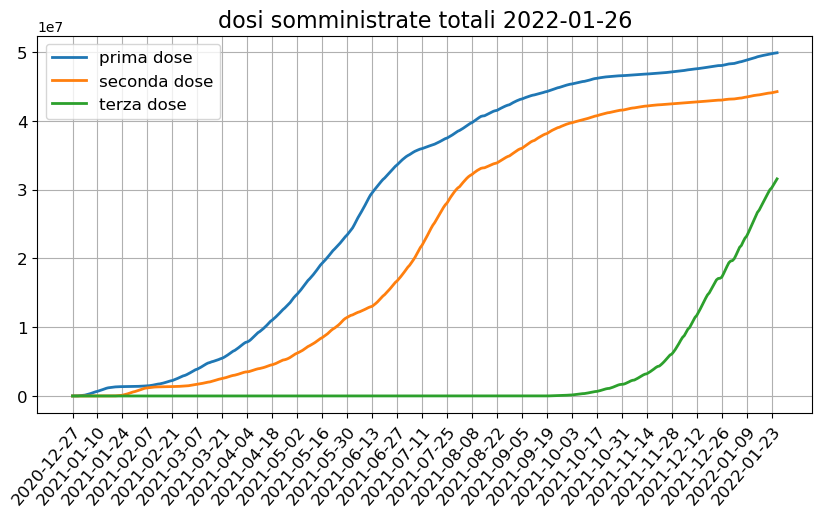

In [27]:
createXYPlot(df_vax_yyyy_mm_dd, 
             y=["totale_prima_dose","totale_seconda_dose", "totale_terza_dose"], 
             labels=["prima dose", "seconda dose", "terza dose"],
             x="data_somministrazione", 
             days_interval=14,
             linewidth=2,
             title=f"dosi somministrate totali {oggi}",
             plots_folder=plots_folder,
             savename=f"dosi_somministrate_cumulativo.png"
            )

### Cumulativa per fornitore

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


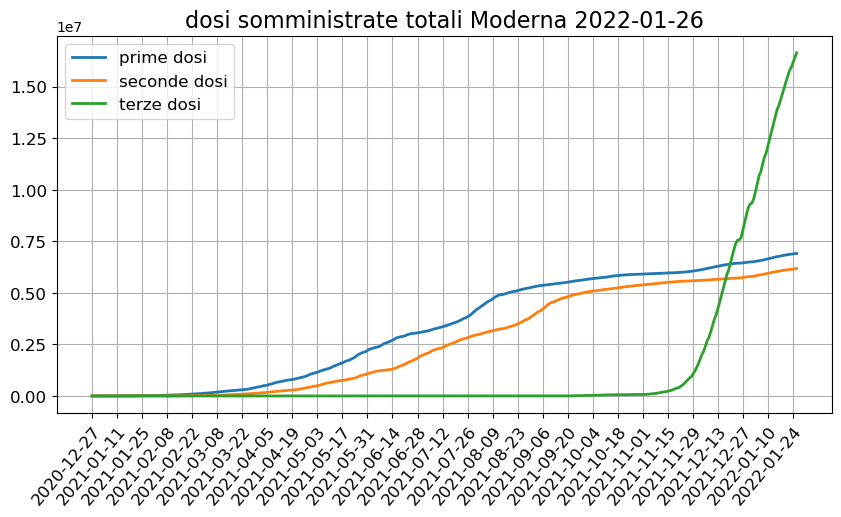

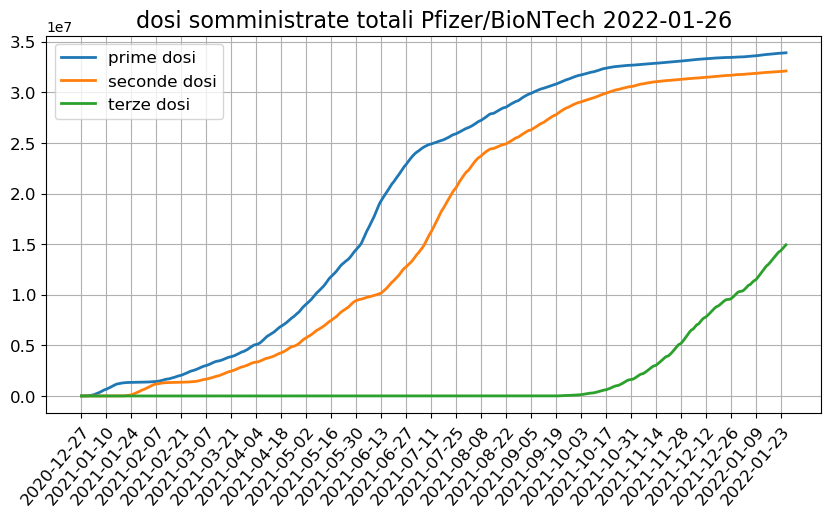

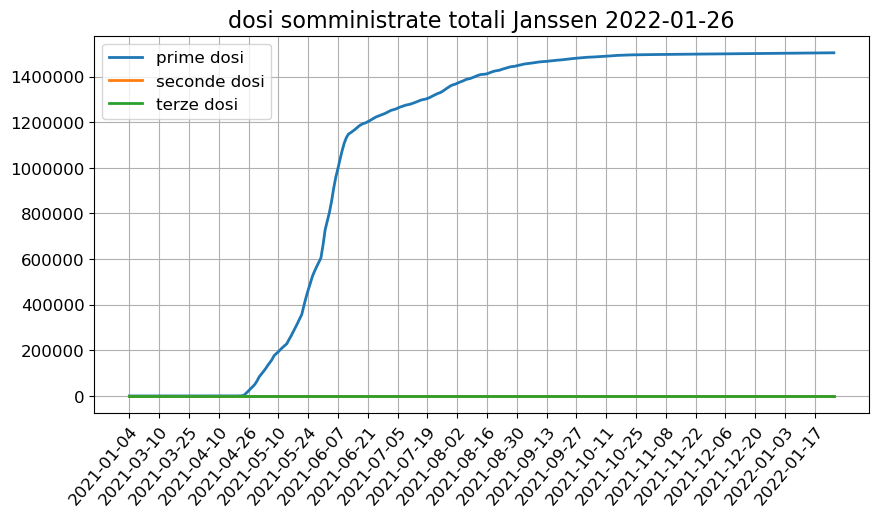

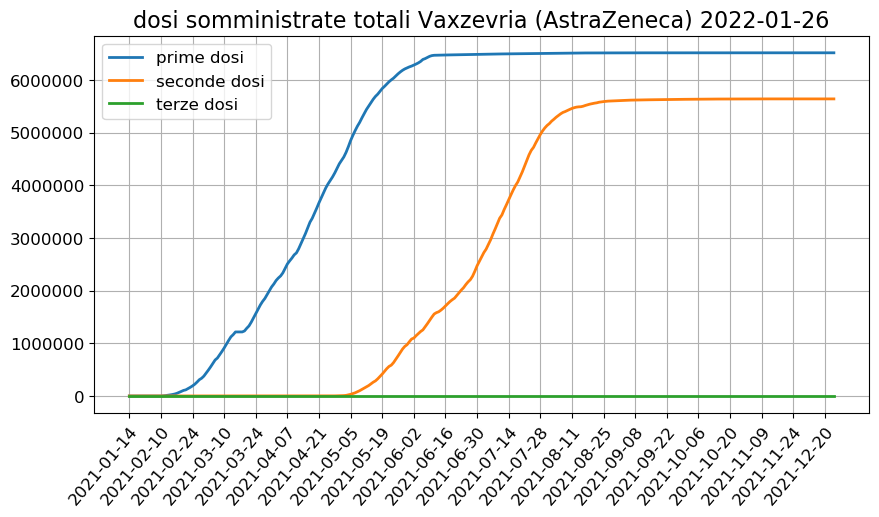

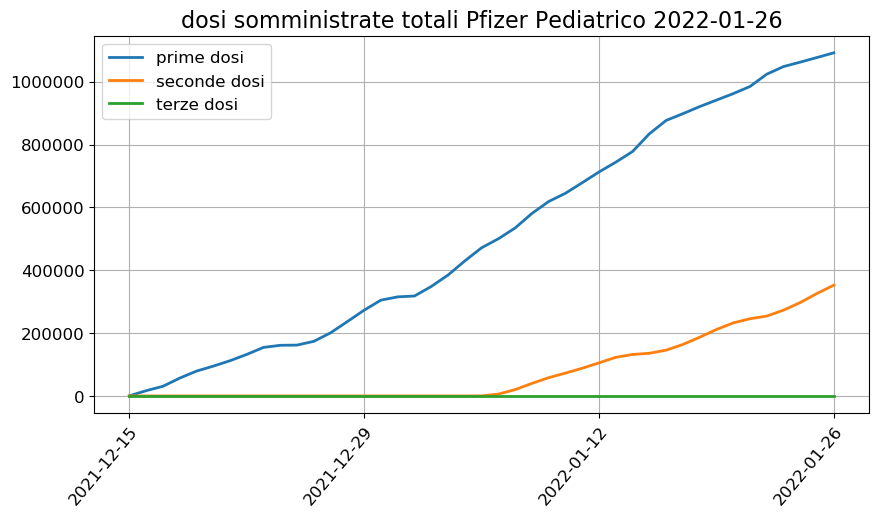

In [28]:
for fornitore in fornitori:
    df_plot = df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore==fornitore]
    df_plot["totale_prima_dose"] = df_plot["prima_dose"].cumsum()
    df_plot["totale_seconda_dose"] = df_plot["seconda_dose"].cumsum()
    df_plot["totale_terza_dose"] = df_plot["terza_dose"].cumsum()
    savename_suffix="_"+fornitore.replace("/","_")    
    createXYPlot(df_plot, 
                 y=["totale_prima_dose","totale_seconda_dose","totale_terza_dose"],
                 labels=["prime dosi","seconde dosi", "terze dosi"],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"dosi somministrate totali {fornitore} {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate_totali_{savename_suffix}.png")

In [29]:
df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag["fascia_anagrafica"]=="05-11"].tail(3)

data_somministrazione fascia_anagrafica  prima_dose  seconda_dose  \
3572            2022-01-24             05-11       14125         24360   
3582            2022-01-25             05-11       14731         28904   
3592            2022-01-26             05-11       14913         26255   

      terza_dose  pregressa_infezione  prima_dose_no_guariti  \
3572           0                   73                  14052   
3582           0                  105                  14626   
3592           0                   72                  14841   

      prima_dose_media_7  seconda_dose_media_7  terza_dose_media_7  \
3572        23435.857143          19064.285714                 0.0   
3582        22316.714286          19919.857143                 0.0   
3592        21501.714286          20162.142857                 0.0   

      prima_dose_no_guariti_media_7  
3572                   23331.142857  
3582                   22209.714286  
3592                   21394.857143

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


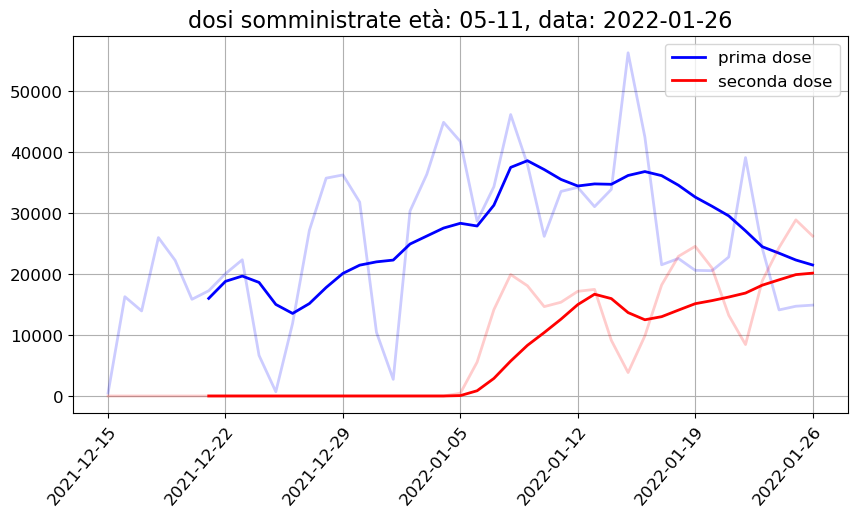

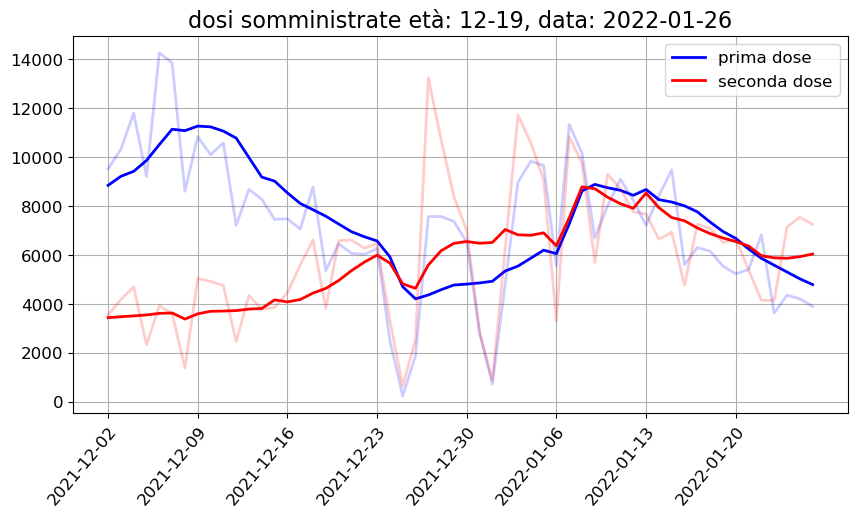

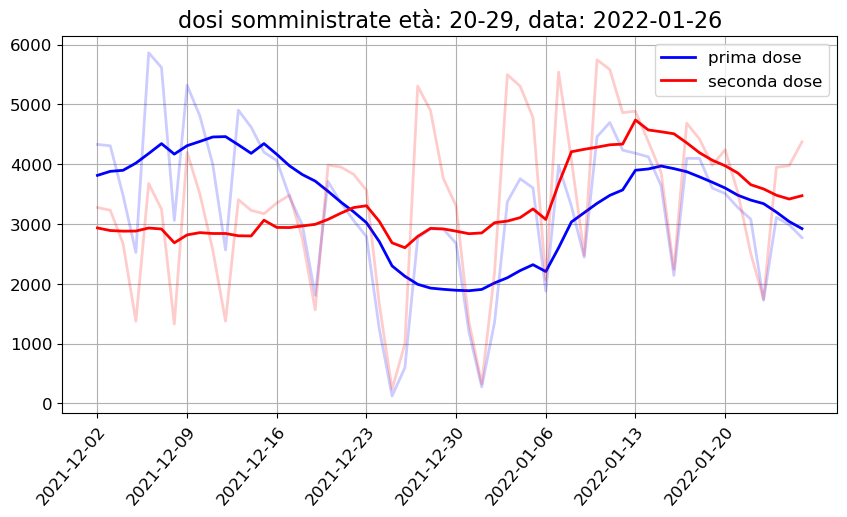

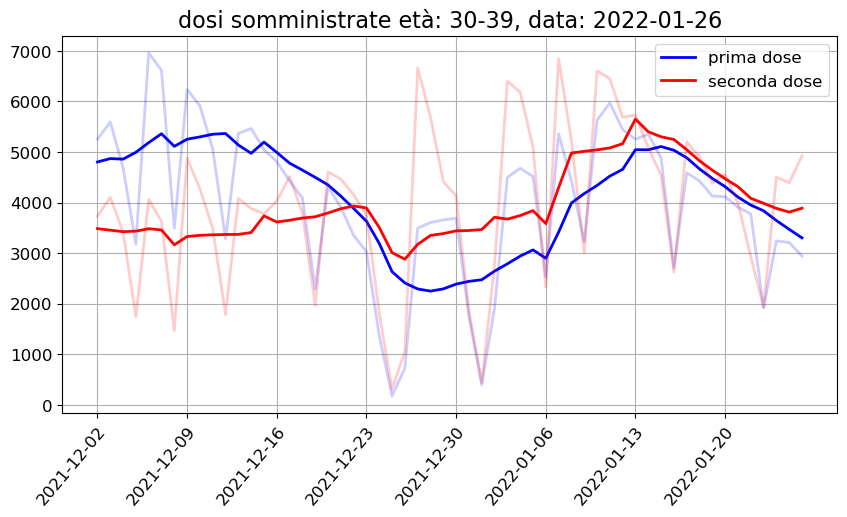

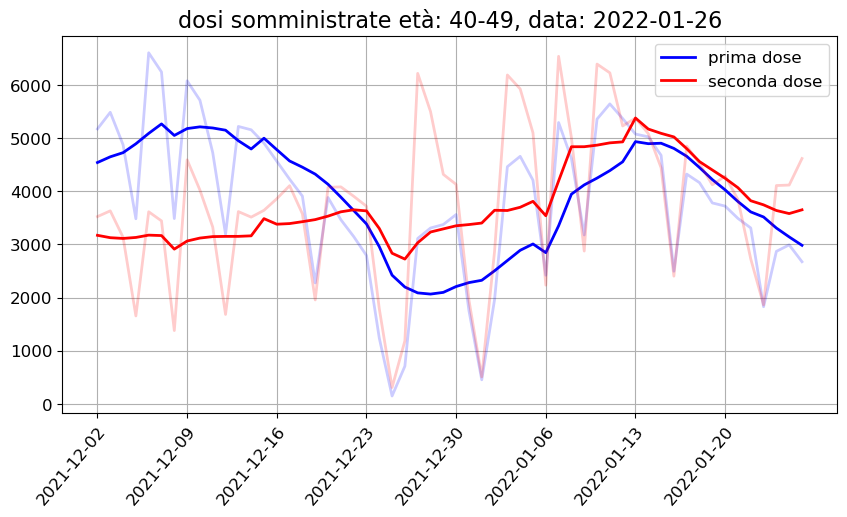

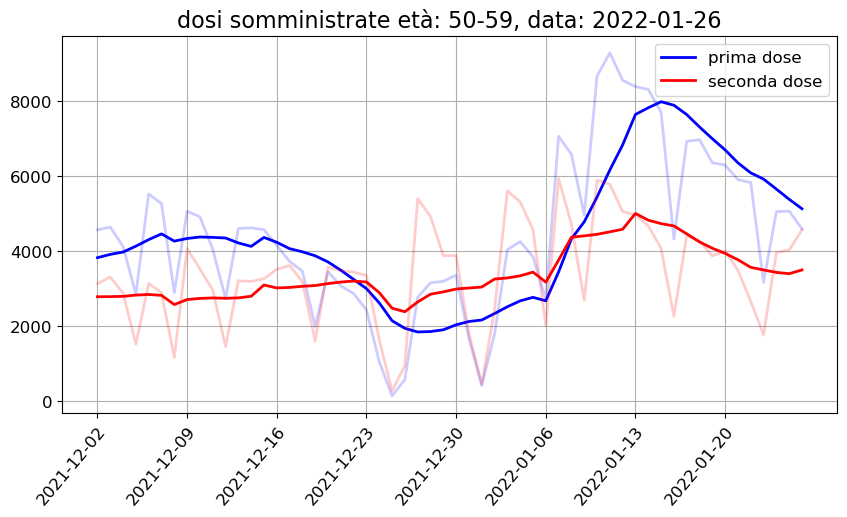

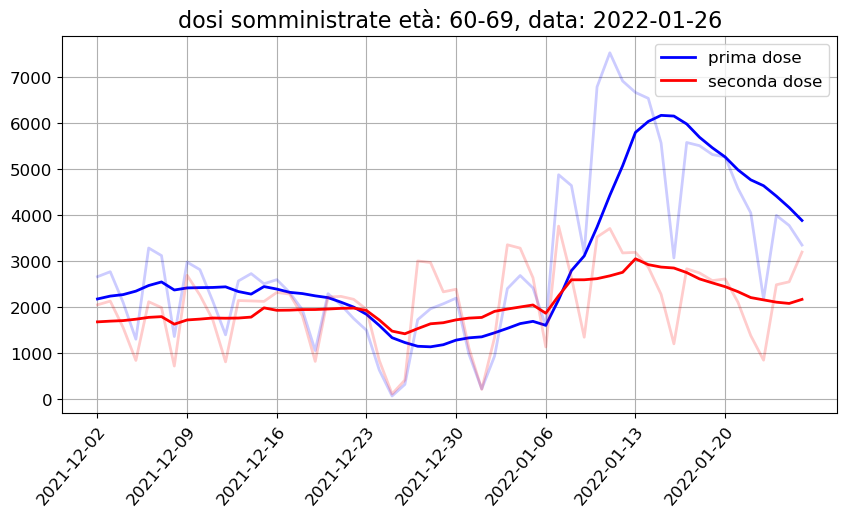

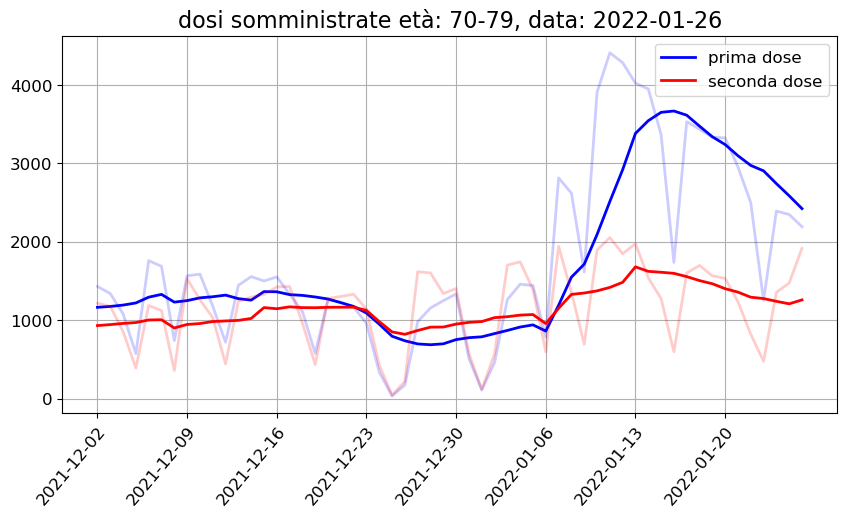

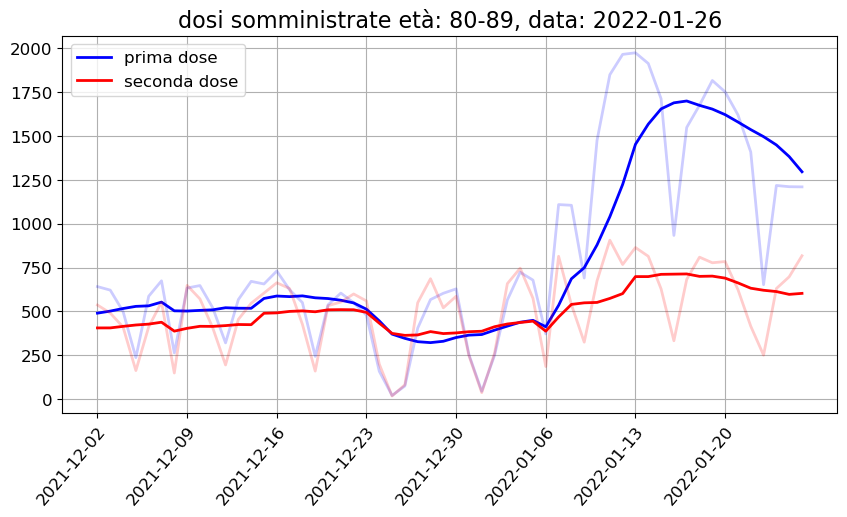

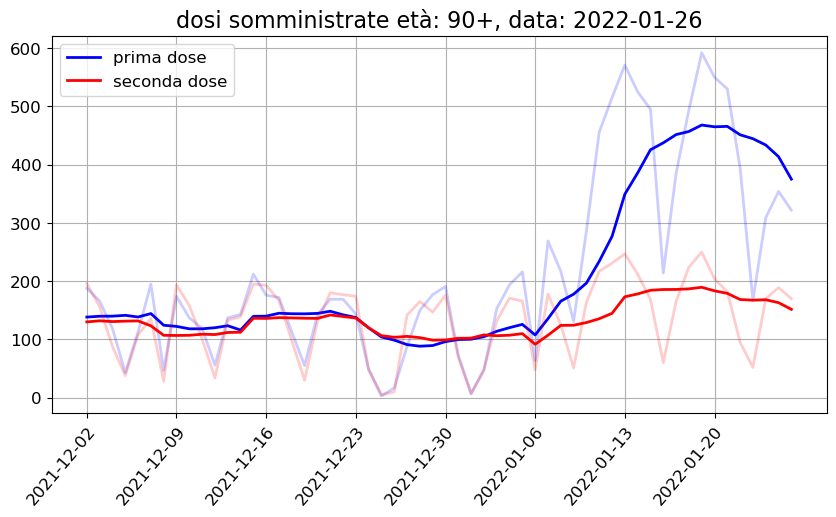

In [30]:
for anag in sorted(df_vax_yyyy_mm_dd_anag["fascia_anagrafica"].unique()):
    savename_suffix="_" + anag  
    df_plot = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica==anag]
    df_plot = df_plot.sort_values(by="data_somministrazione")
    createXYPlot(df_plot, 
                 y=["prima_dose", "prima_dose_media_7", "seconda_dose", "seconda_dose_media_7"], 
                 labels=[None, "prima dose", None, "seconda dose"],
                 colors=["b","b","r","r"],
                 alphas=[0.2,1,0.2,1],
                 x="data_somministrazione", 
                 linewidth=2,
                 days_interval=7,
                 start_date="2021-12-01",
                 title=f"dosi somministrate età: {anag}, data: {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate{savename_suffix}.png")


In [31]:
grid = get_grid(keys=["data_somministrazione","fascia_anagrafica"])

In [32]:
df_vax_yyyy_mm_dd_anag = grid.merge(df_vax_yyyy_mm_dd_anag, on=["data_somministrazione","fascia_anagrafica"], how="left")
df_vax_yyyy_mm_dd_anag = df_vax_yyyy_mm_dd_anag.fillna(0)

In [33]:
df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.data_somministrazione=="2020-12-27"]

data_somministrazione fascia_anagrafica  prima_dose  seconda_dose  \
0            2020-12-27             05-11         0.0           0.0   
1            2020-12-27             12-19         0.0           0.0   
2            2020-12-27             20-29       704.0           0.0   
3            2020-12-27             30-39      1088.0           0.0   
4            2020-12-27             40-49      1508.0           0.0   
5            2020-12-27             50-59      2207.0           0.0   
6            2020-12-27             60-69      1513.0           0.0   
7            2020-12-27             70-79       130.0           0.0   
8            2020-12-27             80-89       118.0           0.0   
9            2020-12-27               90+        78.0           0.0   

   terza_dose  pregressa_infezione  prima_dose_no_guariti  prima_dose_media_7  \
0         0.0                  0.0                    0.0                 0.0   
1         0.0                  0.0                    0.0                 0.0   
2         0.0                  0.0                  704.0                 0.0   
3         0.0                  0.0                 1088.0                 0.0   
4         0.0                  2.0                 1506.0                 0.0   
5         0.0                  3.0                 2204.0                 0.0   
6         0.0                  5.0                 1508.0                 0.0   
7         0.0                  2.0                  128.0                 0.0   
8         0.0                  1.0                  117.0                 0.0   
9         0.0                  2.0                   76.0                 0.0   

   seconda_dose_media_7  terza_dose_media_7  prima_dose_no_guariti_media_7  
0                   0.0                 0.0                            0.0  
1                   0.0                 0.0                            0.0  
2                   0.0                 0.0                            0.0  
3                   0.0                 0.0                            0.0  
4                   0.0                 0.0                            0.0  
5                   0.0                 0.0                            0.0  
6                   0.0                 0.0                            0.0  
7                   0.0                 0.0                            0.0  
8                   0.0                 0.0                            0.0  
9                   0.0                 0.0                            0.0

In [43]:
def dosi_eta(media=True, 
             start_date="2021-10-01",
             days_interval=7
            ):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for dose in ["prima","seconda","terza"]:
        plt.figure(dpi=100,figsize=(11,5))
        col_idx = 0
        for anag in sorted(df_vax_yyyy_mm_dd_anag["fascia_anagrafica"].unique()):
            df_plot = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica==anag]
            df_plot = df_plot[df_plot.data_somministrazione>=start_date]
            x = df_plot["data_somministrazione"].tolist()
            x = [ x[i] for i in range(0,len(x)) if i % days_interval == 0]
            if media:
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose"], alpha=0.2, color=colors[col_idx])
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose_media_7"], label=anag, color=colors[col_idx], linewidth=2.0)
            else:
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose"], alpha=1, label=anag, color=colors[col_idx])

            col_idx +=1
        plt.xticks(x, rotation=60, 
                   rotation_mode="anchor", 
                   verticalalignment = "top", 
                   horizontalalignment = "right",
                   fontsize=12
                  )
        plt.yticks(fontsize=12)
        plt.grid()
        plt.legend()
        if dose == "prima":
            title = "Prime dosi"
        elif dose == "seconda":
            title = "Seconde dosi"
        else:
            title = "Terze dosi"
        plt.title(f"{title} somministrate per fascia d'età",fontsize=16)
        savename=f"{plots_folder}/{dose}_dose_fascia_eta"
        if media:
            savename += "_media"
        plt.savefig(fname=f"{savename}.png",bbox_inches="tight")

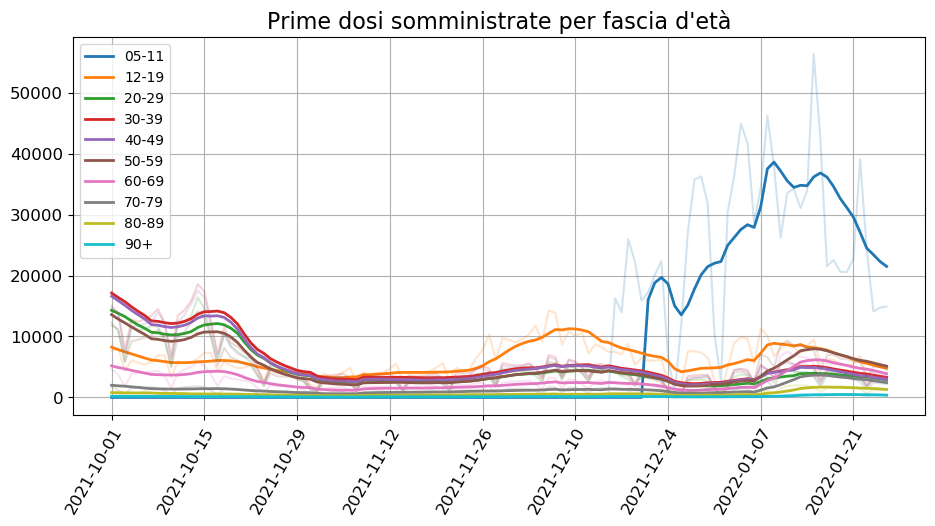

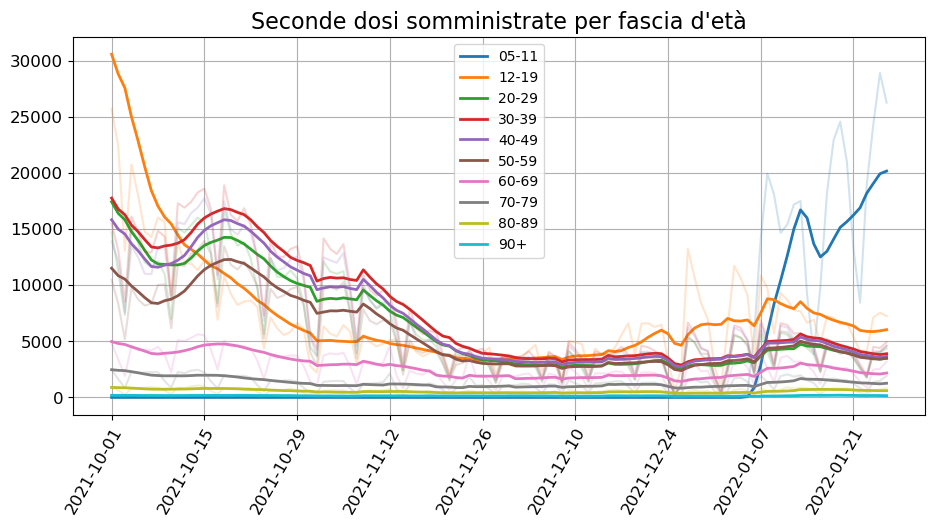

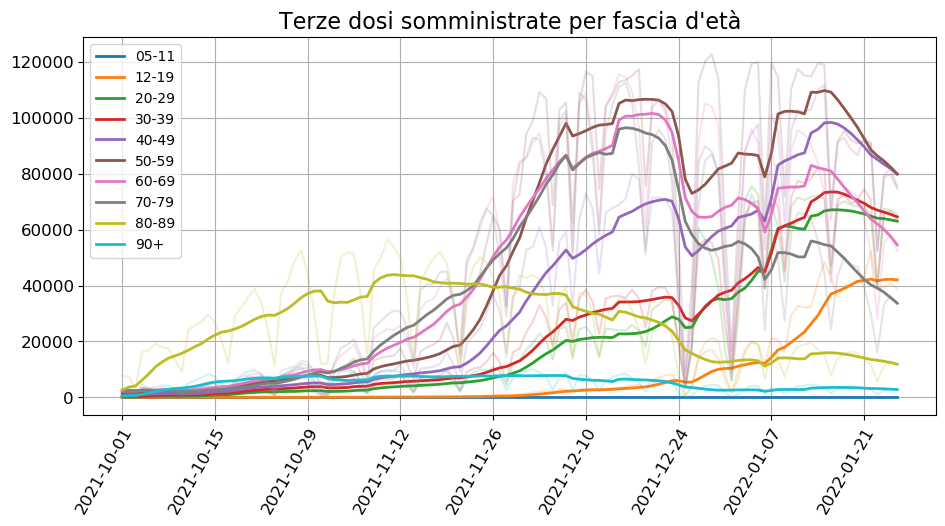

In [46]:
dosi_eta(media=True, start_date="2021-10-01", days_interval=14)

In [36]:
grid = get_grid(keys=["data_somministrazione", "fascia_anagrafica","fornitore"])

In [37]:
df_vax_yyyy_mm_dd_anag_fornitore = grid.merge(df_vax_yyyy_mm_dd_anag_fornitore, on=["data_somministrazione", "fascia_anagrafica","fornitore"],how="left")
df_vax_yyyy_mm_dd_anag_fornitore = df_vax_yyyy_mm_dd_anag_fornitore.fillna(0)

In [31]:
df_vax_yyyy_mm_dd_anag_fornitore[df_vax_yyyy_mm_dd_anag_fornitore.fascia_anagrafica=="05-11"]

data_somministrazione fascia_anagrafica                fornitore  \
0                2020-12-27             05-11                  Janssen   
1                2020-12-27             05-11                  Moderna   
2                2020-12-27             05-11        Pfizer Pediatrico   
3                2020-12-27             05-11          Pfizer/BioNTech   
4                2020-12-27             05-11  Vaxzevria (AstraZeneca)   
...                     ...               ...                      ...   
19450            2022-01-20             05-11                  Janssen   
19451            2022-01-20             05-11                  Moderna   
19452            2022-01-20             05-11        Pfizer Pediatrico   
19453            2022-01-20             05-11          Pfizer/BioNTech   
19454            2022-01-20             05-11  Vaxzevria (AstraZeneca)   

       prima_dose  seconda_dose  terza_dose  pregressa_infezione  \
0             0.0           0.0         0.0                  0.0   
1             0.0           0.0         0.0                  0.0   
2             0.0           0.0         0.0                  0.0   
3             0.0           0.0         0.0                  0.0   
4             0.0           0.0         0.0                  0.0   
...           ...           ...         ...                  ...   
19450         0.0           0.0         0.0                  0.0   
19451         0.0           0.0         0.0                  0.0   
19452     20025.0       20654.0         0.0                 76.0   
19453         0.0           0.0         0.0                  0.0   
19454         0.0           0.0         0.0                  0.0   

       prima_dose_no_guariti  prima_dose_media_7  seconda_dose_media_7  \
0                        0.0                 0.0              0.000000   
1                        0.0                 0.0              0.000000   
2                        0.0                 0.0              0.000000   
3                        0.0                 0.0              0.000000   
4                        0.0                 0.0              0.000000   
...                      ...                 ...                   ...   
19450                    0.0                 0.0              0.000000   
19451                    0.0                 0.0              0.000000   
19452                19949.0             30963.0          15508.714286   
19453                    0.0                 0.0              0.000000   
19454                    0.0                 0.0              0.000000   

       terza_dose_media_7  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
...                   ...  
19450                 0.0  
19451                 0.0  
19452                 0.0  
19453                 0.0  
19454                 0.0  

[1950 rows x 11 columns]

In [32]:
def plot_anag_fornitore(start_date, media=False):
    for dose in ["prima","seconda","terza"]:
        for fornitore in fornitori:
            plt.figure(dpi=100, figsize=(10,4))
            max_val_0 = 0
            col_idx = 0
            for anag in anagrafiche:
                condizione = (df_vax_yyyy_mm_dd_anag_fornitore.fornitore == fornitore) & (df_vax_yyyy_mm_dd_anag_fornitore.fascia_anagrafica==anag)
                df_plot = df_vax_yyyy_mm_dd_anag_fornitore[condizione]
                df_plot = df_plot[df_plot.data_somministrazione>=start_date]
                Xval = df_plot["data_somministrazione"]
                Yval = df_plot[f"{dose}_dose"]
                Yval_media7 = df_plot[f"{dose}_dose_media_7"]
                if media:
                    plt.plot(Xval, Yval, linewidth=1.8, alpha=0.15, color=colors[col_idx])
                    plt.plot(Xval, Yval_media7, label=anag, linewidth=2.0, color=colors[col_idx])
                else:
                    plt.plot(Xval, Yval, linewidth=1.8, alpha=1, color=colors[col_idx],label=anag)
                max_val = np.max(Yval)
                col_idx += 1
                if max_val > max_val_0:
                    max_val_0 = max_val
            x = df_plot["data_somministrazione"].tolist()
            x = [ x[i] for i in range(0,len(x)) if i % 7 == 0]
            plt.xticks(x, rotation=60, 
                       rotation_mode="anchor", 
                       verticalalignment = "top", 
                       horizontalalignment = "right",
                       fontsize=12
                      )
            plt.yticks(fontsize=12)
            plt.grid()
            plt.legend()
            if dose == "prima":
                title = "Prime dosi"
            elif dose == "seconda":
                title = "Seconde dosi"
            else:
                title = "Terze dosi"
            title = f"{title} somministrate per fascia d'età"
            if media:
                title += ", media 7 giorni, "
            title += f" {fornitore}"
            savename = f"{plots_folder}/{dose}_dose_{fornitore.replace('/','_')}_eta"
            if media:
                savename += "_media7"
            savename += ".png"
            plt.title(title, fontsize=16)
            plt.savefig(fname=savename,bbox_inches="tight")

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


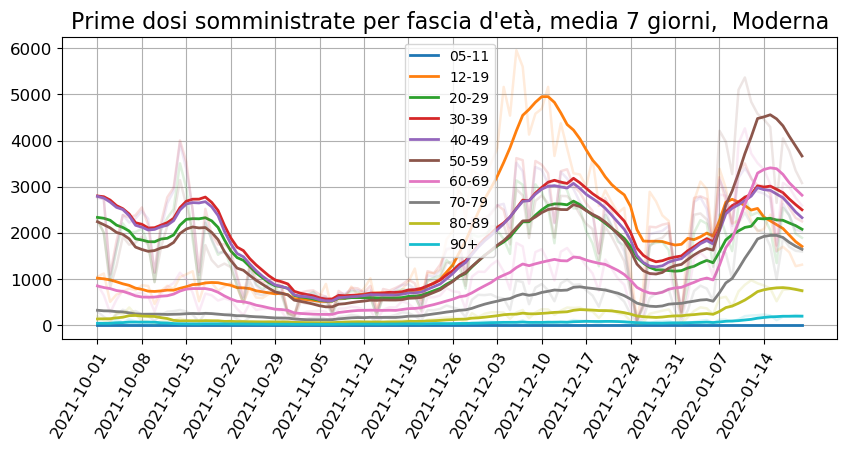

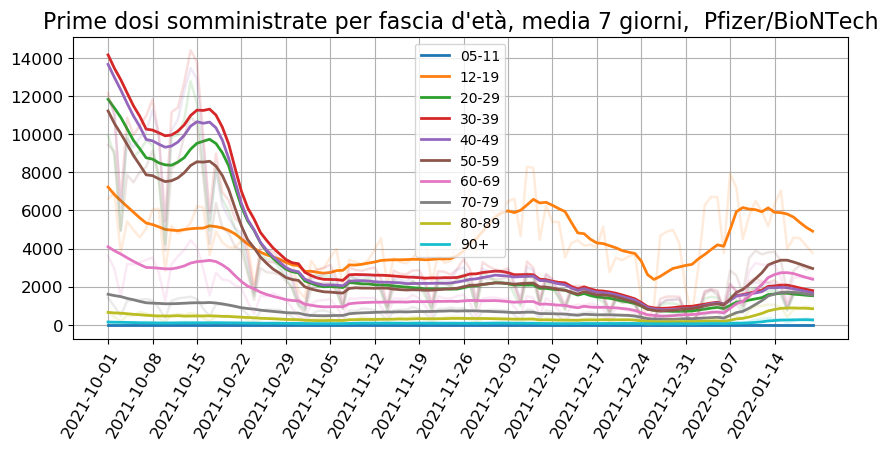

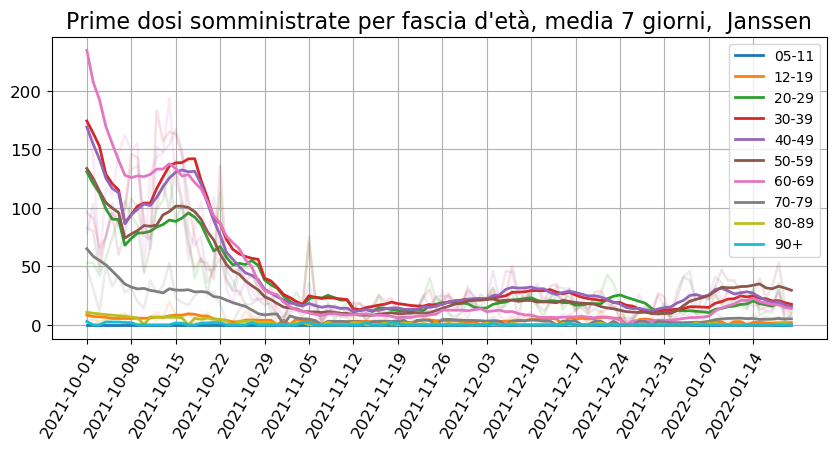

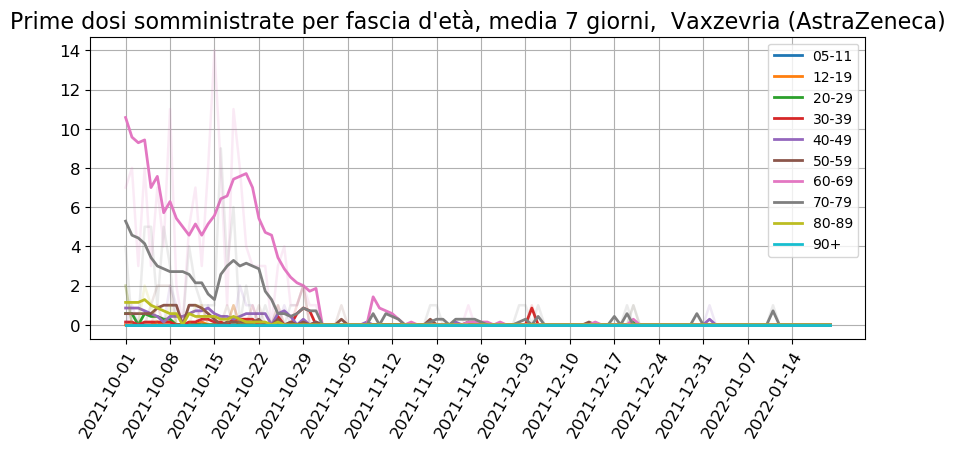

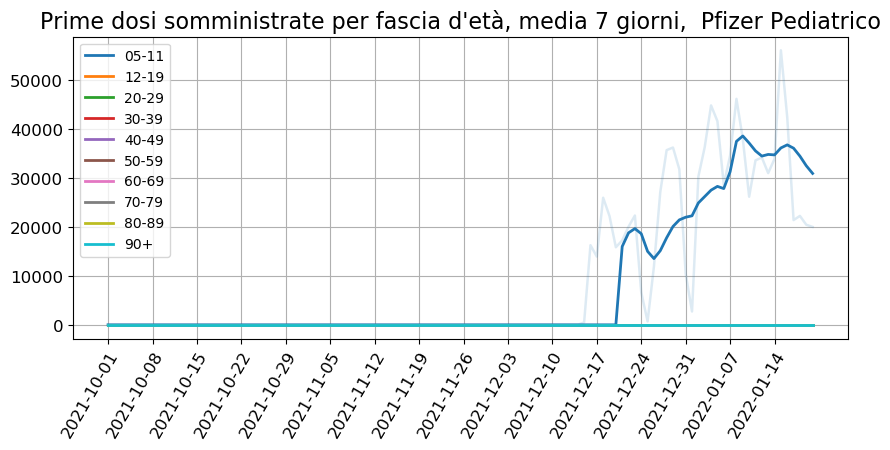

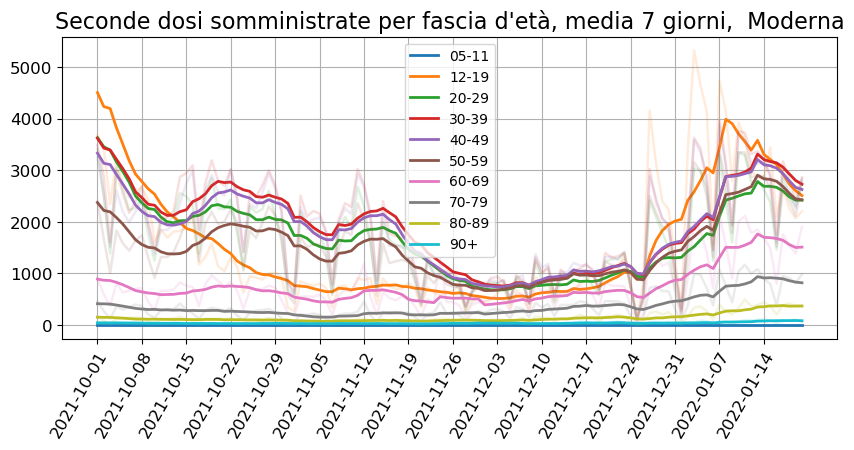

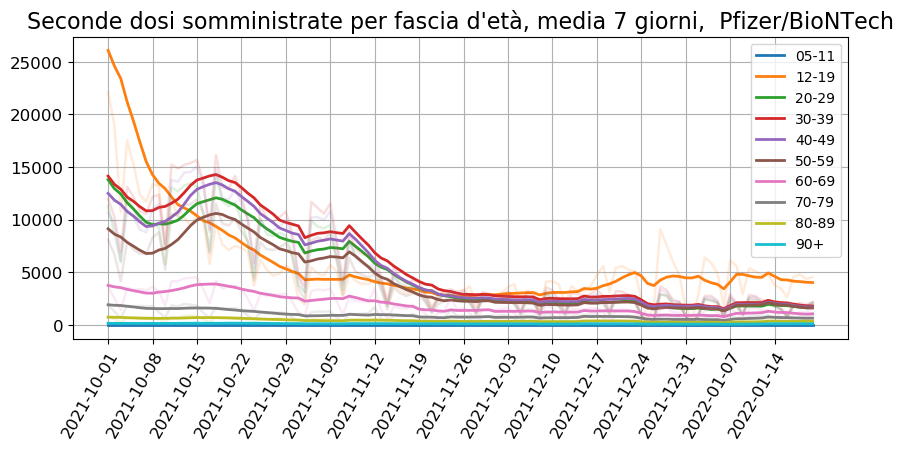

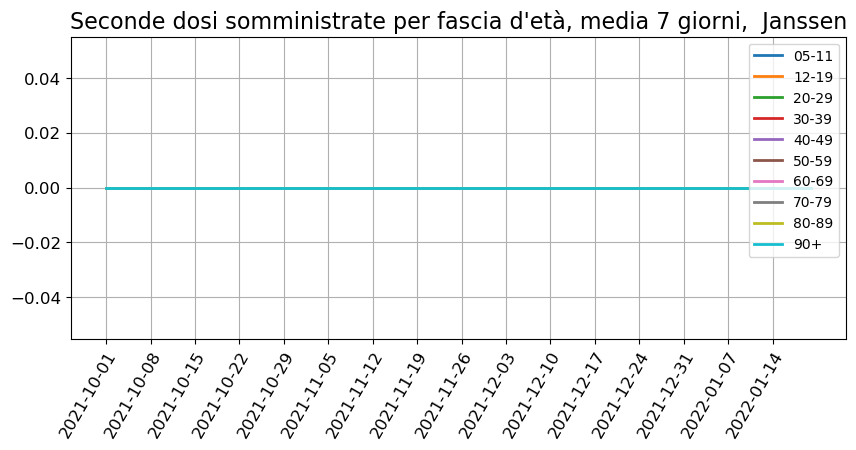

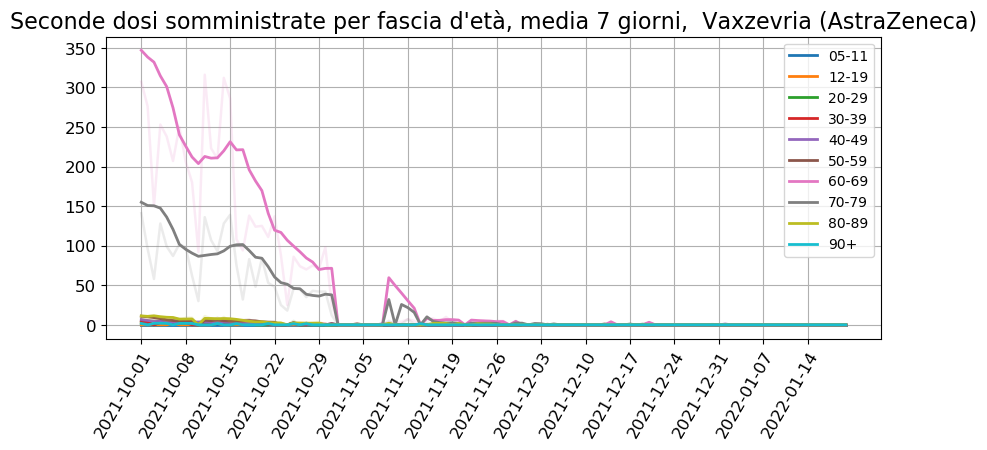

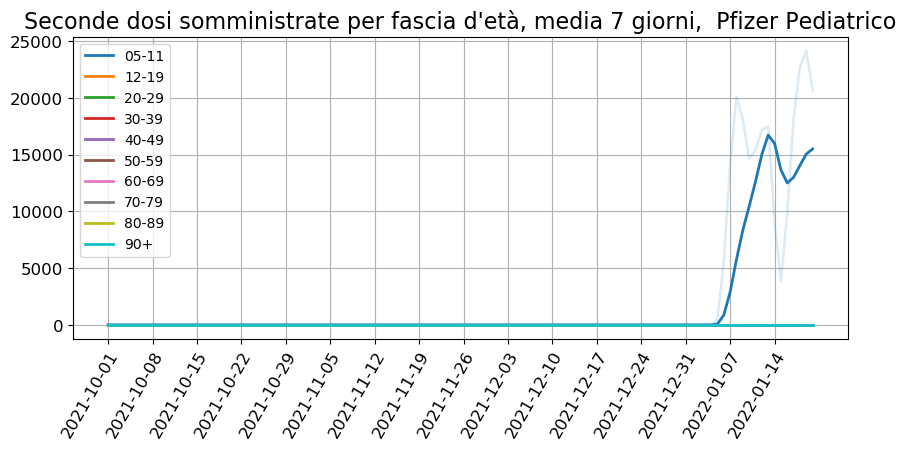

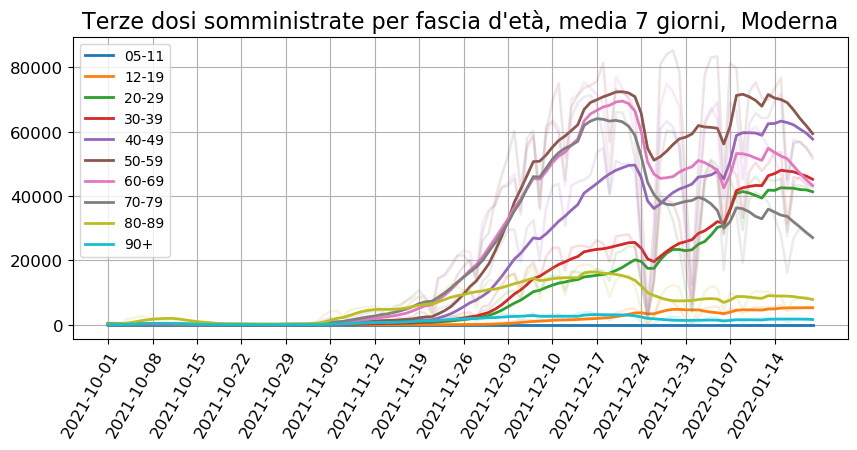

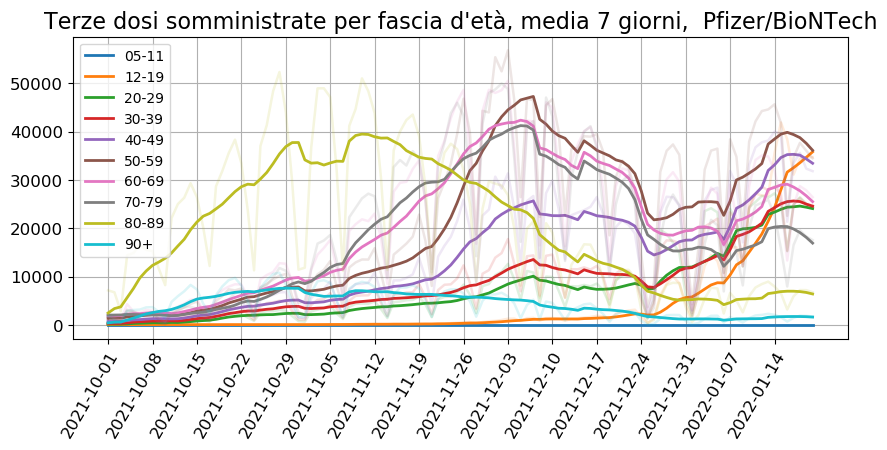

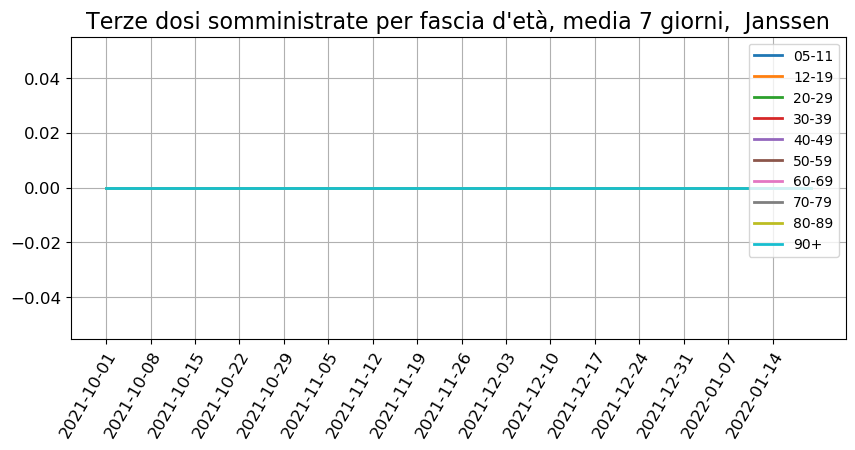

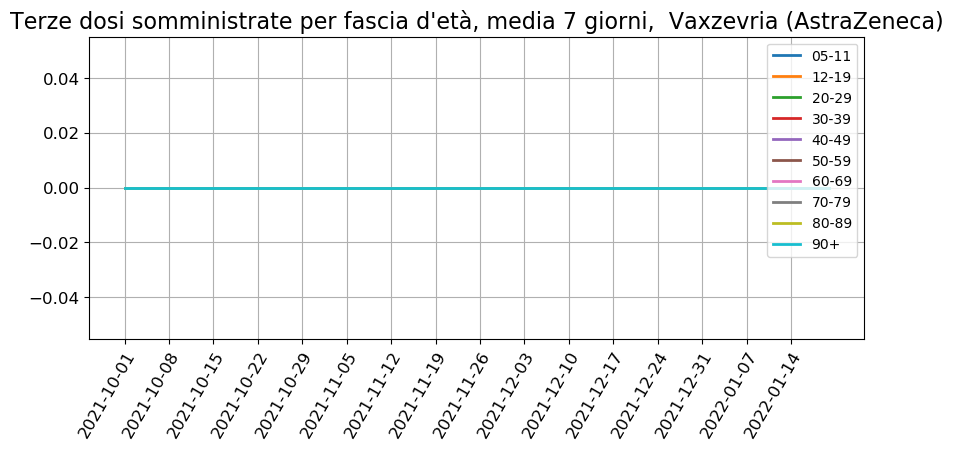

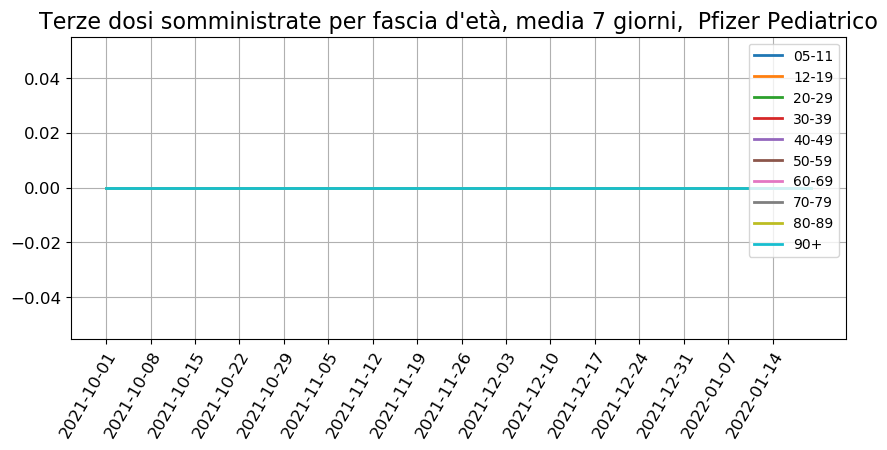

In [33]:
plot_anag_fornitore(start_date="2021-10-01", media=True)

In [344]:
popolazione = pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/platea.csv")
popolazione = popolazione.groupby("fascia_anagrafica").sum().reset_index()

In [349]:
pop_over_50 = popolazione[popolazione.fascia_anagrafica.isin(["50-59","60-69","70-79","80+"])]
display(pop_over_50)
np.sum(pop_over_50["totale_popolazione"])

fascia_anagrafica  totale_popolazione
5             50-59             9645613
6             60-69             7552718
7             70-79             6018697
8               80+             4574312

27791340

In [356]:
prime_dosi_over_50 = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica.isin(["50-59","60-69","70-79","80-89","90+"])][["data_somministrazione","fascia_anagrafica","prima_dose"]]
np.sum(prime_dosi_over_50["prima_dose"])

25751403

In [358]:
prime_dosi_over_50

data_somministrazione fascia_anagrafica  prima_dose
3               2020-12-27             50-59        2207
4               2020-12-27             60-69        1513
5               2020-12-27             70-79         130
6               2020-12-27             80-89         118
7               2020-12-27               90+          78
...                    ...               ...         ...
3536            2022-01-20             50-59        6074
3537            2022-01-20             60-69        5093
3538            2022-01-20             70-79        3203
3539            2022-01-20             80-89        1617
3540            2022-01-20               90+         475

[1948 rows x 3 columns]

In [357]:
27791340-25751403

2039937